In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/TinyMPC/julia/quadrotor_quat/Project.toml`


In [364]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random; 
using Printf
using ControlSystems

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


In [3]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [4]:
#Quadrotor parameters
m = 0.03
ℓ = 0.046
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81
thrustToTorque = 0.005964552
ℓ = 0.046/sqrt(2)
scale = 65535
kt = 2.245365e-6*scale # u is PWM in range [0...1]
km = kt*thrustToTorque #4.4733e-8


h = 1/50 #50 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)
thist = Array(range(0,h*(Nt-1), step=h));

In [5]:
function quad_dynamics(x,u)
  r = x[1:3]
  q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
  v = x[8:10]
  ω = x[11:13]
  Q = qtoQ(q)
  
  ṙ = Q*v
  q̇ = 0.5*L(q)*H*ω
  
  v̇ = Q'*[0; 0; -g] + (1/m)*[zeros(2,4); kt*ones(1,4)]*u - hat(ω)*v
  
  ω̇ = J\(-hat(ω)*J*ω + [0 ℓ*kt 0 -ℓ*kt; -ℓ*kt 0 ℓ*kt 0; km -km km -km]*u)
  
  return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u)
  #RK4 integration with zero-order hold on u
  f1 = quad_dynamics(x, u)
  f2 = quad_dynamics(x + 0.5*h*f1, u)
  f3 = quad_dynamics(x + 0.5*h*f2, u)
  f4 = quad_dynamics(x + h*f3, u)
  xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
  xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
  return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [6]:
#Goal state
uhover = (0.5)*ones(4)  # m = 30g and max thrust = 60g
rg = [0.0; 0; 1.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

In [75]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u 
end

discrete_dynamics (generic function with 1 method)

In [274]:
# Adaptive step in MPC horizon: use normal dt and model in the first specified 
# `adaptive_step` steps and after that use the stretch mode (larger dt and model)
h = 1/10 #25 Hz stretch interval dynamics
#Linearize dynamics about hover
As = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
Bs = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ãs = Array(E(qg)'*As*E(qg))
B̃s = Array(E(qg)'*Bs);
function discrete_dynamics_stretch(params,x,u,k)
  Ãs*x + B̃s*u
end

discrete_dynamics_stretch (generic function with 1 method)

In [420]:
h = 1/50 #50 Hz normal dynamics
display(Ãs)
display(Ã)

12×12 Matrix{Float64}:
 1.0  0.0  0.0   0.0     0.0981  0.0  …  0.0  0.0   0.0       0.001635  0.0
 0.0  1.0  0.0  -0.0981  0.0     0.0     0.1  0.0  -0.001635  0.0       0.0
 0.0  0.0  1.0   0.0     0.0     0.0     0.0  0.1   0.0       0.0       0.0
 0.0  0.0  0.0   1.0     0.0     0.0     0.0  0.0   0.05      0.0       0.0
 0.0  0.0  0.0   0.0     1.0     0.0     0.0  0.0   0.0       0.05      0.0
 0.0  0.0  0.0   0.0     0.0     1.0  …  0.0  0.0   0.0       0.0       0.05
 0.0  0.0  0.0   0.0     1.962   0.0     0.0  0.0   0.0       0.04905   0.0
 0.0  0.0  0.0  -1.962   0.0     0.0     1.0  0.0  -0.04905   0.0       0.0
 0.0  0.0  0.0   0.0     0.0     0.0     0.0  1.0   0.0       0.0       0.0
 0.0  0.0  0.0   0.0     0.0     0.0     0.0  0.0   1.0       0.0       0.0
 0.0  0.0  0.0   0.0     0.0     0.0  …  0.0  0.0   0.0       1.0       0.0
 0.0  0.0  0.0   0.0     0.0     0.0     0.0  0.0   0.0       0.0       1.0

12×12 Matrix{Float64}:
 1.0  0.0  0.0   0.0       0.003924  0.0  …  0.0    0.0       1.308e-5  0.0
 0.0  1.0  0.0  -0.003924  0.0       0.0     0.0   -1.308e-5  0.0       0.0
 0.0  0.0  1.0   0.0       0.0       0.0     0.02   0.0       0.0       0.0
 0.0  0.0  0.0   1.0       0.0       0.0     0.0    0.01      0.0       0.0
 0.0  0.0  0.0   0.0       1.0       0.0     0.0    0.0       0.01      0.0
 0.0  0.0  0.0   0.0       0.0       1.0  …  0.0    0.0       0.0       0.01
 0.0  0.0  0.0   0.0       0.3924    0.0     0.0    0.0       0.001962  0.0
 0.0  0.0  0.0  -0.3924    0.0       0.0     0.0   -0.001962  0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     1.0    0.0       0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     0.0    1.0       0.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0  …  0.0    0.0       1.0       0.0
 0.0  0.0  0.0   0.0       0.0       0.0     0.0    0.0       0.0       1.0

In [543]:
# IHLQR terminal cost
P = [zeros(nx,nx) for i = 1:200]   # cost to go quadratic term
p = [zeros(nx) for i = 1:200]      # cost to go linear term
d = [zeros(nu) for i = 1:200-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:200-1] # feedback gain

# Cost weights
Q = Array(Diagonal([10; 10; 10; 1; 1; 1; 1; 1; 1; 1; 1; 1.]));
R = Array(I(Nu));
Qf = Q

P[200] = Q
for k = (200-1):-1:1
    K[k] .= (R + B̃s'*P[k+1]*B̃s)\(B̃s'*P[k+1]*Ãs)
    P[k] .= Q + Ãs'*P[k+1]*(Ãs - B̃s*K[k])
end
Qf = P[1]

12×12 Matrix{Float64}:
 83.5443        -0.000875101   7.25279e-15  …   1.79368       0.00394093
 -0.000875101   83.5436       -8.22279e-15     -0.000322299  -0.00158225
  1.19168e-14   -2.6853e-16   46.7503           3.88173e-16  -2.34106e-14
  0.00428124   -87.2994        2.97486e-14      0.00184579    0.00935587
 87.303         -0.00428124    5.07259e-14      8.52114       0.0233021
  0.0039403     -0.001582     -1.51635e-14  …   0.00221631    0.527131
 25.721         -0.00068765    6.12649e-15      1.37246       0.0033031
 -0.00068765    25.7205       -5.83291e-15     -0.000267408  -0.00132618
  4.52253e-15    9.23365e-15   3.59042          2.50854e-16  -1.08913e-14
  0.000322299   -1.79341      -1.2277e-15       0.00017318    0.000925551
  1.79368       -0.000322299   6.41209e-15  …   1.19224       0.00230516
  0.00394093    -0.00158225   -1.67988e-14      0.00230516    1.04101

In [600]:
#Feedback tracking controller
include("tinyMPC_dt.jl")
nx = Nx̃
nu = Nu
N = 5
dt = h
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)

#Create trajectory to follow
Xref = [[0;0;1;1;zeros(9)] for i = 1:Nt]
Δx̃ref = [zeros(nx) for i = 1:Nt]
ΔUref = [zeros(nu) for i = 1:Nt-1]

## Number-eight
# Xref = [[1*cos(t)*sin(t);1*cos(t);1;1;zeros(9)] for t = range(0, 2*pi + 1*pi/4, length = Nt)]  

## Triangle
p0 = [0; 0; 1.0]; p1 = [3; 4; 1.]; p2 = [0; 8; 1.]; p3 = [0; -3; 1.0]
range1 = collect(LinRange(p0, p1, round(Int,(Nt)/3)))
range2 = collect(LinRange(p1, p2, round(Int,(Nt)/3)))
range3 = collect(LinRange(p2, p3, round(Int,(Nt)/3)+1))
range123 = [range1; range2; range3]
for k = 1:Nt
    Xref[k][1:3] .= range123[k]
end

for i = 1:Nt-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
end
for k = 1:Nt
    x = Xref[k]
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)   
    Δx̃ref[k] .= [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
end

u_min = -1*uhover
u_max =  1*uhover

# state is x y v θ
x_min = -100*ones(nx)
x_min[3] = -0.3
x_max = 100*ones(nx)
x_max[3] = 0.3

ncx = 2*nx*0
ncu = 2*nu*1
ncg = 0
ncu_cone = nu*0; 
cone_scale = 1e-3  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(0)]
 
# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# new MPC iterate
Xn = deepcopy(X)
Un = deepcopy(U)

params = (
    nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone, c_cone = c_cone,
    N = N, Q = Q, R = R, Qf = Q,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = ΔUref, dt = dt,
);

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

function controller_mpc(params, x, k)
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)
    
    Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
    X[1] .= Δx̃
    # u = mpc_JuMP(optimizer, params, X, U, Ã, B̃, 0.0; warm_start=true)
    u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=10,max_inner_iters=5,verbose=false,ρ=1e0,ρ_max=1e6, ϕ=10.0, adaptive_step=1)
    return u + uhover
end

#ASK: Do I need to stretch the reference?
function update_reference(params, k)
    Uref_ = 1*ΔUref[k:N+k-1]
    Xref_ = 1*Δx̃ref[k:N+k]
    # for i = 3:N-1
    #     Uref_[i] .= ΔUref[k+i*2-2]
    #     Xref_[i] .= Δx̃ref[k+i*2-2]
    # end
    # Xref_[N] .= Δx̃ref[k+N*2-2]
    params1 = (; params..., Uref = Uref_, Xref = Xref_)  # update ref
    return params1
end


update_reference (generic function with 1 method)

In [594]:
# Simulation
uhist = [zeros(Nu) for i in 1:Nt-1]
xhist = [zeros(Nx) for i in 1:Nt]
Random.seed!(12);
# xhist[1] .= [rg+randn(3)/3; L(qg)*rptoq([1; 0; 0]); vg; ωg]  # initial conditions
xhist[1] .= Xref[1]
# xhist[1] .= Xref[1]; xhist[1][1:3] += rand(3)*0.2
for k = 1:(Nt-2*N-2)
    params1 = update_reference(params, k)
    # display(params1.Xref[1][1:3])
    # display(xhist[k][1:3])
    # shift_fill(U)
    uhist[k] = controller_mpc(params1, xhist[k], k)
    # uhist[k] = clamp.(uhist[k], (uhover+u_min)[1], (uhover+u_max)[1])
    xhist[k+1] = quad_dynamics_rk4(xhist[k],uhist[k]) 
end

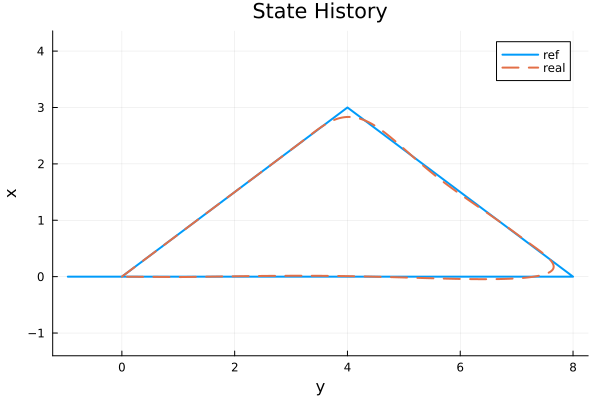

In [596]:
Xsim_m = mat_from_vec(Xref[1:1:Nt-2*N])
plot(Xsim_m[2,:],Xsim_m[1,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="y", ylabel="x")
Xsim_m = mat_from_vec(xhist[1:1:Nt-2*N])   
display(plot!(Xsim_m[2,:],Xsim_m[1,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))

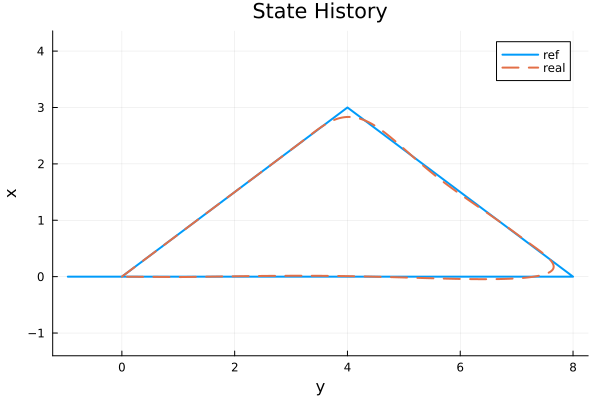

In [597]:
Xsim_m = mat_from_vec(Xref[1:1:Nt-2*N])
plot(Xsim_m[2,:],Xsim_m[1,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="y", ylabel="x")
Xsim_m = mat_from_vec(xhist[1:1:Nt-2*N])   
display(plot!(Xsim_m[2,:],Xsim_m[1,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))

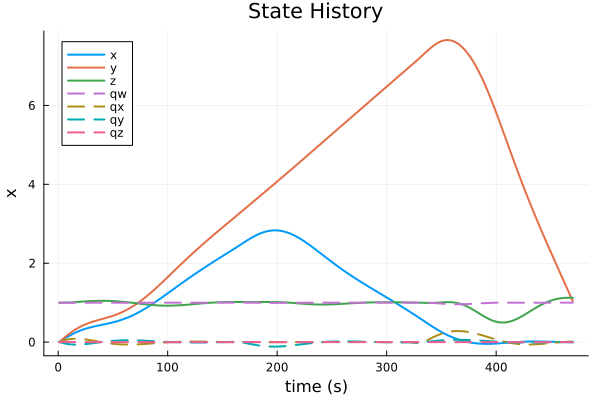

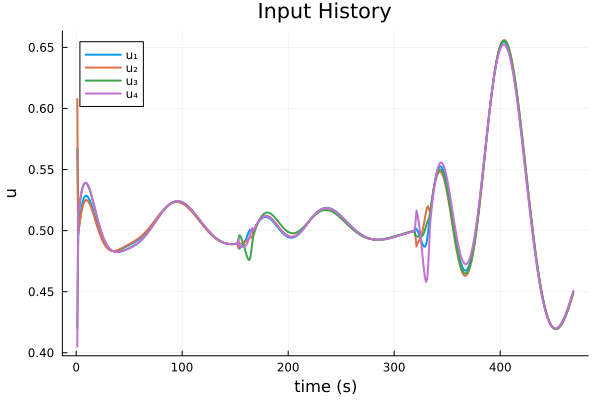

In [598]:
Xsim_m = mat_from_vec(xhist[1:Nt-2*N-1])   
Usim_m = mat_from_vec(uhist[1:Nt-2*N-2])   
display(plot(Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))

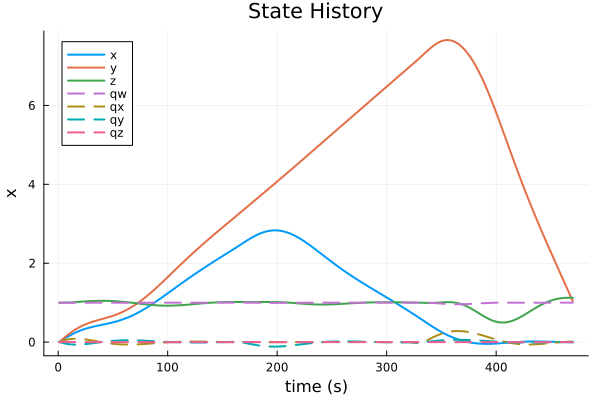

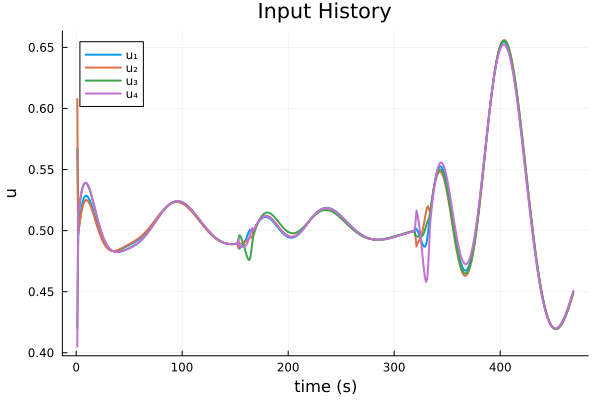

In [599]:
Xsim_m = mat_from_vec(xhist[1:Nt-2*N-1])   
Usim_m = mat_from_vec(uhist[1:Nt-2*N-2])   
display(plot(Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))